In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to the folder containing the CSV files
folder_path = "/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/GD_Calc_Data_Last_10_Rows"
output_folder_path = os.path.join(folder_path, "non_dominated")

# Create output directory if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

def is_dominated(point, other_point):
    """
    Returns True if point is dominated by other_point.
    """
    return all(o <= p for p, o in zip(point, other_point)) and any(o < p for p, o in zip(point, other_point))

def extract_non_dominated_solutions(df):
    """
    Extract non-dominated solutions from a DataFrame.
    """
    points = df.values
    non_dominated_mask = np.ones(len(points), dtype=bool)
    for i, point in enumerate(points):
        for j, other_point in enumerate(points):
            if i != j and is_dominated(point, other_point):
                non_dominated_mask[i] = False
                break
    return df[non_dominated_mask]

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Extract non-dominated solutions
        non_dominated_df = extract_non_dominated_solutions(df)
        
        # Save the non-dominated solutions to a new CSV file
        output_file_path = os.path.join(output_folder_path, f"non_dominated_{file_name}")
        non_dominated_df.to_csv(output_file_path, index=False)

print(f"Non-dominated solutions saved in {output_folder_path}")

Non-dominated solutions saved in /Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/GD_Calc_Data_Last_10_Rows/non_dominated


In [12]:
import os
import pandas as pd

# Define the path to the folder containing the non-dominated CSV files
folder_path = "/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts"

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Drop duplicate rows
        df_cleaned = df.drop_duplicates()
        
        # Save the cleaned DataFrame back to the CSV file (overwrite)
        df_cleaned.to_csv(file_path, index=False)

print(f"Duplicates removed from all files in {folder_path}")


Duplicates removed from all files in /Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/GD_Calc_Data_Last_10_Rows/non_dominated


started prcessing strategy: 1_


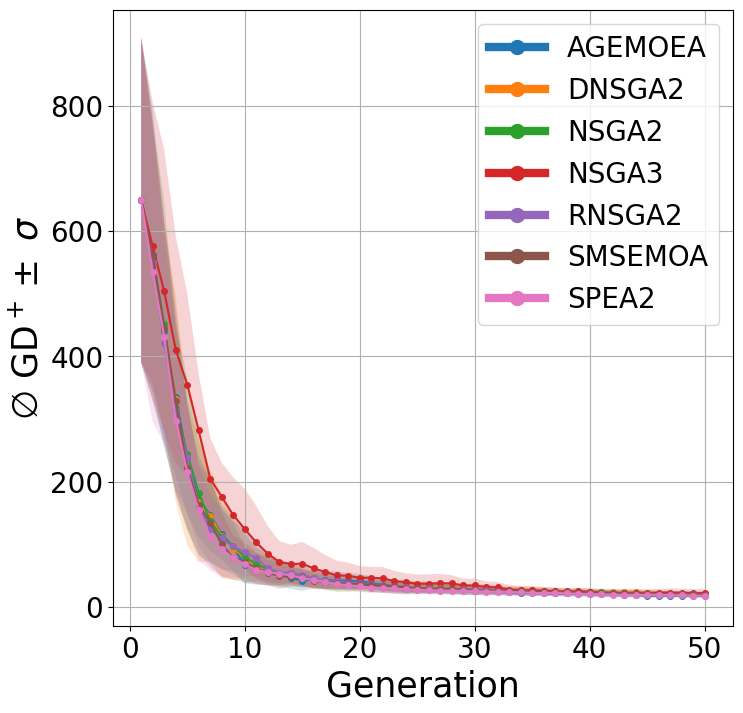

started prcessing strategy: 2_


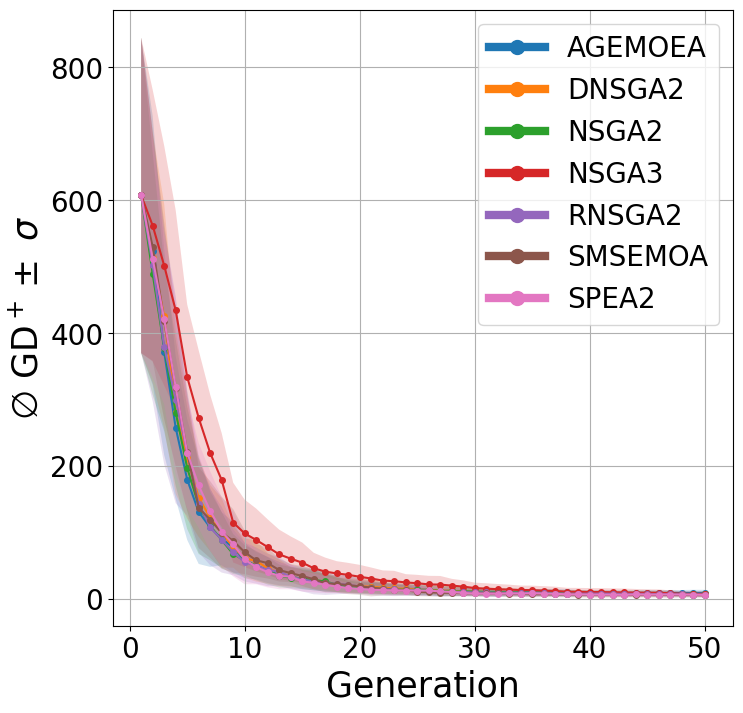

started prcessing strategy: 3_


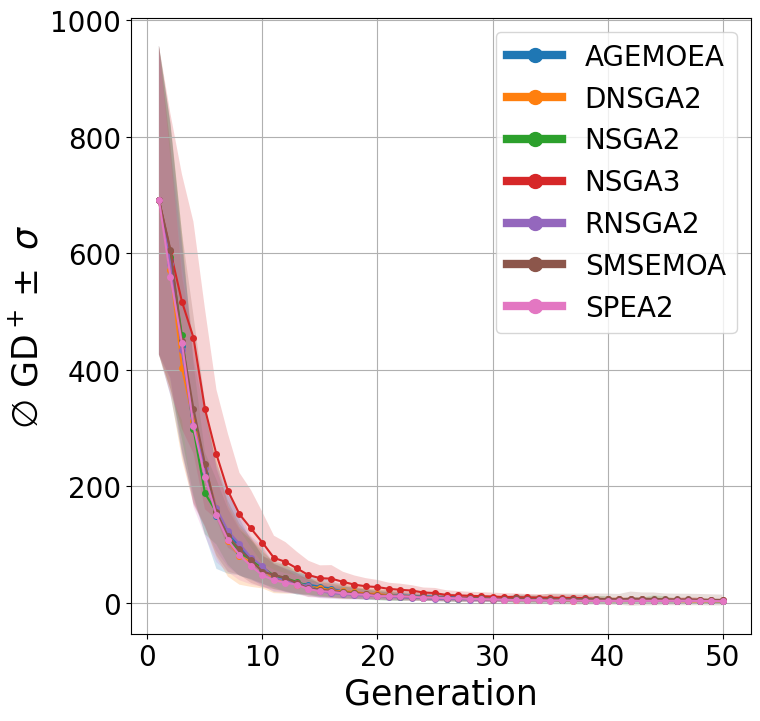

started prcessing strategy: 4_


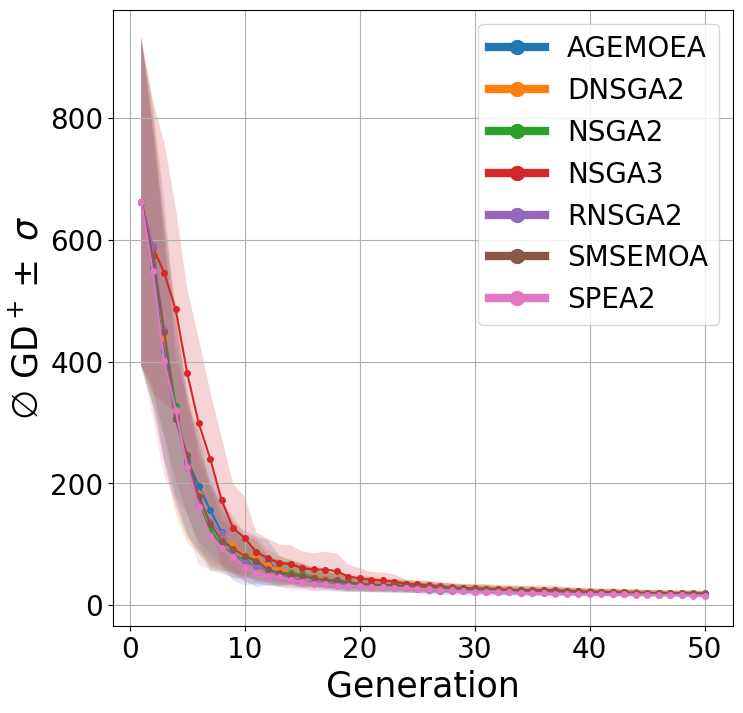

started prcessing strategy: 5_


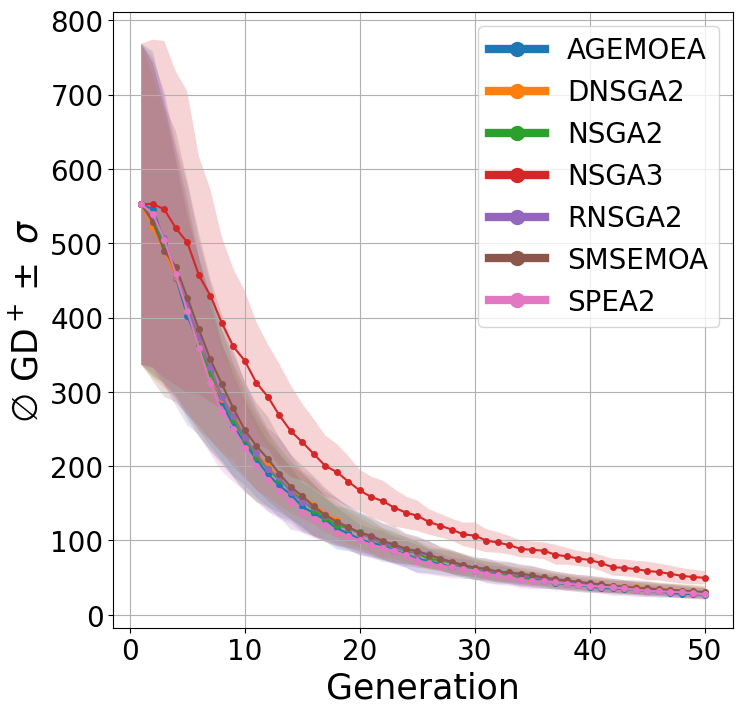

In [17]:
import os
import re
import pandas as pd
import numpy as np
from pymoo.indicators.gd_plus import GDPlus
import matplotlib.pyplot as plt

# Directory containing the log folders
base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/meanderingRiverMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/gradientMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/radialGradientMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/sinusoidalMap'

# List of algorithms to analyze
algorithms = ["_AGEMOEA_", "_DNSGA2_", "_NSGA2_", "_NSGA3_", "_RNSGA2_", "_SMSEMOA_", "_SPEA2_"]

# List of shifting strategies to analyze
shifting_strategies = ["1_", "2_", "3_", "4_", "5_"]

# Base directory for true Pareto fronts
true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_meanderingRiverMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_gradientMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_radialGradientMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_sinusoidalMap_{}_objective_values.csv'

# Number of generations to consider
num_generations = 50

# Loop through each shifting strategy
for strategy in shifting_strategies:
    print(f"started prcessing strategy: {strategy}")
    # Construct the path for the true Pareto front specific to the current shifting strategy
    true_pareto_path = true_pareto_base_path.format(strategy[0])
    
    # Load the True Pareto Front
    true_pareto_front = pd.read_csv(true_pareto_path)
    true_pareto_array = true_pareto_front.to_numpy()

    # Initialize the GD+ indicator with the true Pareto front
    gd_plus_indicator = GDPlus(true_pareto_array)

    # Prepare the plot for the current shifting strategy
    plt.figure(figsize=(8, 8))

    # Dictionary to store mean and std GD+ values for each algorithm
    gd_dict = {}

    # Loop through each algorithm
    for algorithm in algorithms:
        # Define the pattern to match folder names for the current algorithm and shifting strategy
        pattern = rf'^meanderingRiverObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^gradientObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^radialGradientObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^sinusoidalObstacles{algorithm}{strategy}\d+$'

        # Get all matching folders for this algorithm and shifting strategy
        matching_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if re.match(pattern, f)]

        # Initialize a list to store GD+ values by seed for the current algorithm and shifting strategy
        gd_plus_values_list = []

        # Loop over each matching folder
        for folder in matching_folders:
            # Load the log data containing the objective values
            opt_log_path = os.path.join(folder, 'optLog.csv')
            opt_log = pd.read_csv(opt_log_path)

            # Convert string representation of objective values into numpy arrays
            opt_log[' objectiveValues'] = opt_log[' objectiveValues'].apply(eval)
            generations_objectives = opt_log[' objectiveValues'].to_numpy()

            # Trim to the first num_generations generations
            generations_objectives = generations_objectives[:num_generations]

            # Calculate GD+ for each generation
            gd_plus_values = [gd_plus_indicator.do(np.array(gen)) for gen in generations_objectives]

            # Store in list
            gd_plus_values_list.append(gd_plus_values)

        # Convert the list of lists into a numpy array
        gd_plus_array = np.array(gd_plus_values_list)

        if gd_plus_array.size > 0:
            # Calculate the mean and standard deviation along the first axis (across seeds)
            mean_gd_plus = np.mean(gd_plus_array, axis=0)
            std_gd_plus = np.std(gd_plus_array, axis=0)

            # Store the results in the dictionary
            gd_dict[algorithm] = (mean_gd_plus, std_gd_plus)

    # Plotting all algorithms for the current shifting strategy
    for algo, (mean_gd_plus, std_gd_plus) in gd_dict.items():
        if len(mean_gd_plus) > 0:
            plt.plot(range(1, len(mean_gd_plus) + 1), mean_gd_plus, marker='o', markersize=4, label=f'{algo.strip("_")}')
            plt.fill_between(range(1, len(mean_gd_plus) + 1), mean_gd_plus - std_gd_plus, mean_gd_plus + std_gd_plus, alpha=0.2)

    # Final plot adjustments for the current shifting strategy
    plt.xlabel('Generation', fontsize=25)
    plt.ylabel(r'$\varnothing$ GD$^+ \pm$ $\sigma$', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(20)
    
    #plt.title('Hypervolume Over Generations for Different Algorithms')
    legend = plt.legend(fontsize=20)
    for line in legend.get_lines():
        line.set_linewidth(6)
        line.set_markersize(10)
    
    
    plt.grid(True)
    plt.show()
